In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
wind_power_station_varphi=[1,6]
wind_power_station_v_in=[3,5]
wind_power_station_v_out=[25,25]
wind_power_station_v_r=[13,15]
wind_power_station_sigma_ue=[5,5]
wind_power_station_sigma_oe=[30,20]
wind_power_station_P_r=[160,160]
wind_power_station_P_min=[0,0]
wind_power_station_P_max=[160,160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=3
regularization_parameter=0.001
small_Gaussian_Byzantine_attack=np.loadtxt("./data/small_Gaussian_Byzantine_attack_(-150,5).txt")

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=70
thermal_power_station_strategy[1][0]=70
thermal_power_station_strategy[2][0]=70
thermal_power_station_strategy[3][0]=70
wind_power_station_strategy[0][0]=70
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=350
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=small_Gaussian_Byzantine_attack[0]

#火力，风力发电对偶初始化
thermal_power_station_dual_variable[0][0]=-70
thermal_power_station_dual_variable[1][0]=-70
thermal_power_station_dual_variable[2][0]=-70
thermal_power_station_dual_variable[3][0]=-70
wind_power_station_dual_variable[0][0]=-70

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

#计算每个发电站的邻居发电站
neighbor_robust1_help=[]
for i in range (0,6):
    for j in range (0,6):
        if E[i][j]!=0:
            neighbor_robust1_help.append(j)
        elif E[i][j]==0:
            neighbor_robust1_help.append(99)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(6,6)

#计算安全的发电站的拜占庭邻居用户数量
q_robust1=[]
for i in range(0,6):
    q_robust1_help=0
    for j in range(0,6):
        if neighbor_robust1[i][j]==5:
            q_robust1_help=q_robust1_help+1
    q_robust1.append(q_robust1_help)

In [4]:
def TM_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        
        #TM鲁棒聚合+adaptive clipping 安全的火力发电站的对偶更新
        #在做鲁棒聚合前 对收集到的信息进行adaptive clipping的剪裁操作         
        for i in range (0,4):
            u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
            if i==0 or i==3:
                u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
                u_neighbor_help_robust1.remove(99)            
            if int(q_robust1[i])==1: #只有具有拜占庭邻居的用户才需要先进行adaptive clipping和后续的TM聚合操作
                #先进行adaptive clipping
                dual_variable_intermediate_auxiliary=[]
                #注意必须以这样的方式赋值 不能直接写dual_variable_intermediate_auxiliary=dual_variable_intermediate
                #不然在修改变量dual_variable_intermediate_auxiliary的同时也会对dual_variable_intermediate进行修改
                for j in range(len(dual_variable_intermediate)): 
                    dual_variable_intermediate_auxiliary.append(dual_variable_intermediate[j])
                dual_variable_receive=[]
                clipping_C=0
                for j in range(0, len(u_neighbor_help_robust1)):
                    dual_variable_receive.append(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])
                dual_variable_receive.sort()
                clipping_C=-dual_variable_receive[1] #确定clpping的阈值
                #接下来对大于clipping_C的值进行clipping
                for j in range(0, len(u_neighbor_help_robust1)):
                    if -dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]>clipping_C:
                        dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]=-clipping_C            
                #接下来做TM鲁棒聚合   
                u_neighbor_help_robust1.remove(i)
                mix_sum_dual_robust1=0
                sort_list_robust1=[]
                sum_robust1=0
                for j in range (0,len(u_neighbor_help_robust1)):
                    sort_list_robust1.append(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])
                sort_list_robust1.sort()
                #剔除最大的q个数据和最小的q个数据
                for j in range(0,int(q_robust1[i])):
                    del sort_list_robust1[len(sort_list_robust1)-j-1]
                for j in range(0,int(q_robust1[i])):
                    del sort_list_robust1[0]     
                for j in range(0,len(sort_list_robust1)):
                    mix_sum_dual_robust1=mix_sum_dual_robust1+sort_list_robust1[j]
                #诚实用户将剩下的数据和自身的数据做平均操作
                thermal_power_station_dual_variable[i][k]=(1/(len(u_neighbor_help_robust1)+1-2*q_robust1[i]))*(dual_variable_intermediate[i]+mix_sum_dual_robust1)     
            else: #没有拜占庭邻居的用户直接进行平均聚合即可
                mix_sum_dual_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):
                    mix_sum_dual_robust1=mix_sum_dual_robust1+dual_variable_intermediate[u_neighbor_help_robust1[j]]
                thermal_power_station_dual_variable[i][k]=1/len(u_neighbor_help_robust1)*mix_sum_dual_robust1      
        
        #聚合 安全的风力发电站的对偶更新
        u_neighbor_help_robust1=neighbor_robust1[4].tolist()
        u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
        u_neighbor_help_robust1.remove(99)
        mix_sum_dual_robust1=0
        for j in range(0,len(u_neighbor_help_robust1)):
            mix_sum_dual_robust1=mix_sum_dual_robust1+dual_variable_intermediate[u_neighbor_help_robust1[j]]
        wind_power_station_dual_variable[0][k]=1/len(u_neighbor_help_robust1)*mix_sum_dual_robust1           
        
        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=wind_power_station_dual_variable[1][k-1]            
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=small_Gaussian_Byzantine_attack[k]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧平均用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")
        
        #step_size_primal=(pow(k+1,0.1))
        #step_size_dual=1/(pow(k+1,0.7))#我们发现在在线算法中 不能使用太小的对偶步长 不然后续算法对在线变化会不敏感 
        
        '''#尝试使用两阶段的步长
        if k<=500:
            step_size_dual=1/(pow(k+1,0.7))
        else:
            step_size_dual=0.1'''

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
TM_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 70.0
第 2 个火力发电站的初始计划发电量为: 70.0
第 3 个火力发电站的初始计划发电量为: 70.0
第 4 个火力发电站的初始计划发电量为: 70.0
第 5 个风力发电站的初始计划发电量为: 70.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: -70.0
第 2 个火力发电站的初始对偶变量为: -70.0
第 3 个火力发电站的初始对偶变量为: -70.0
第 4 个火力发电站的初始对偶变量为: -70.0
第 5 个风力发电站的初始对偶变量为: -70.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.59297205
****************************************************************************
安全发电站的初始总发电量: 350.0
*************************
需求侧平均用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
*******************************************************

对偶变量迭代步长为: 3
****************************************************************************
926 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 60.83684983045088
第 2 个火力发电站的计划发电量为: 66.83906765100714
第 3 个火力发电站的计划发电量为: 51.290993497278144
第 4 个火力发电站的计划发电量为: 66.73350747977209
第 5 个风力发电站的计划发电量为: 57.3845971625561
第 6 个风力发电站的计划发电量为: -148.96745199
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.15335403815106
第 2 个火力发电站的对偶变量为: -68.53900450531916
第 3 个火力发电站的对偶变量为: -68.94365533267461
第 4 个火力发电站的对偶变量为: -69.0440752155977
第 5 个风力发电站的对偶变量为: -68.15335403815106
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -149.59297205
****************************************************************************
安全发电站的总发电量: 303.0850156210643
*************************
需求侧平均用电需求: 68.97511071
****************************************************************************
风速分布参数c: 20.09010512
****************************************

In [6]:
#数据存储
np.savetxt('./data/03_TM_optimal_parameters_small_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/03_TM_optimal_parameters_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/03_TM_optimal_parameters_small_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[430.6414073699998,
 380.5538758299999,
 357.74585819999993,
 551.2598197499997,
 654.5546008099996,
 1039.0103928999997,
 1258.72092368,
 3320.29861807,
 3852.2925525600003,
 4477.99968701,
 4579.7551372,
 5339.808254220001,
 5767.9564281,
 6092.70396115,
 6783.451898560001,
 7104.72744162,
 7352.26467217,
 8057.74461465,
 8348.143179319999,
 8255.781688389998,
 8200.480019749997,
 8548.441086279996,
 8421.590877699997,
 8304.205364169997,
 8770.667633679997,
 8567.325845879997,
 8368.331601399997,
 8828.139400759997,
 9305.958187609996,
 10305.611558309996,
 11210.868360139997,
 11705.619359659997,
 12338.859706399997,
 12958.348555339999,
 14382.28042864,
 15016.156393750001,
 15308.503365270002,
 16363.928442830003,
 16912.388032060004,
 17119.044633970003,
 17082.132316000003,
 16683.49160924,
 16939.19058535,
 16651.41273723,
 16538.80861299,
 16628.07205153,
 17480.1818333,
 17595.79666406,
 17687.32945787,
 18164.62051256,
 18864.07942933,
 19405.223135019998,
 20096.6740548399

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

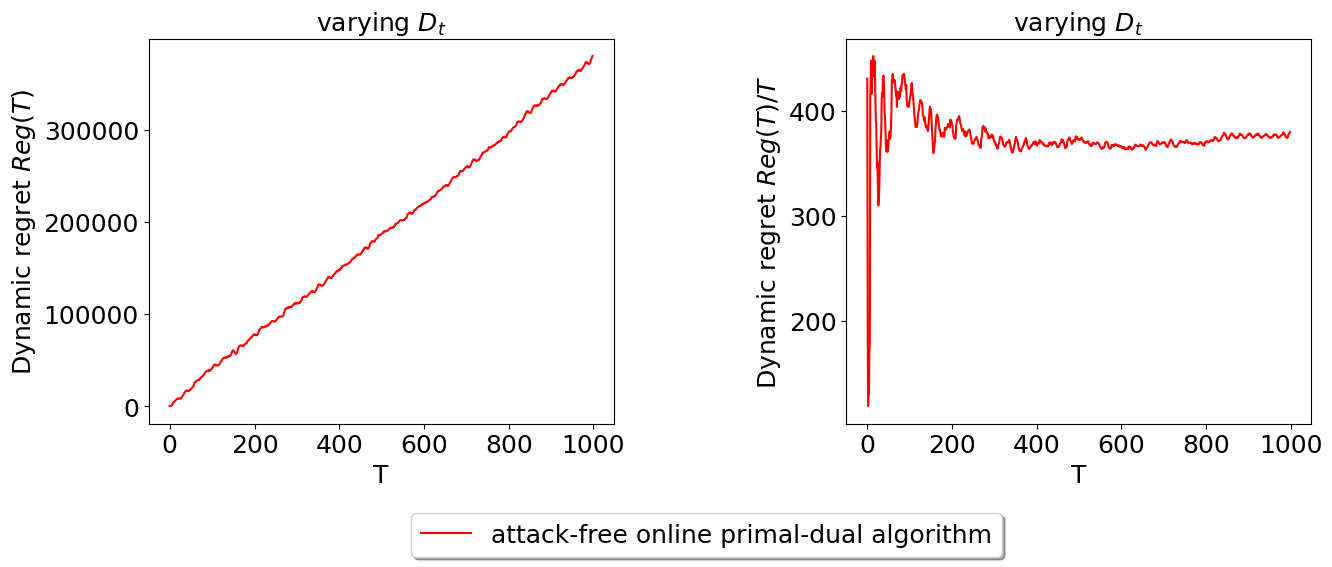

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/03_TM_optimal_parameters_small_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation

[5.161334969999999,
 3.1631070959999903,
 0.2803965320000117,
 1.874499880000016,
 0.2017069179999993,
 2.3645425800000055,
 5.957601142000016,
 18.45336270400003,
 26.83874421000003,
 19.855292216000024,
 18.287835084000022,
 31.082530268000028,
 38.27198713000004,
 42.722972642000045,
 54.13469433600005,
 59.75668352800007,
 57.83460947000006,
 54.25238959800005,
 59.352951268000055,
 55.14104672400006,
 48.85215025600006,
 44.323400200000066,
 38.20436101200008,
 29.07673628400009,
 33.78087572400009,
 27.16658610600011,
 21.01772835200012,
 27.18699018200013,
 31.96257855200014,
 44.66668696600014,
 59.43516830600015,
 60.42910350600016,
 69.98322885000017,
 78.55029280200017,
 93.4615505180002,
 102.2407416700002,
 106.82500854400018,
 126.40646870400018,
 132.23957680800018,
 129.03518574000017,
 125.00126217000016,
 108.96961479200017,
 99.24472180000016,
 93.01706378200016,
 87.49511196400016,
 86.43333294800014,
 83.25629283400013,
 84.05164802600015,
 80.23028034200016,
 81.2

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

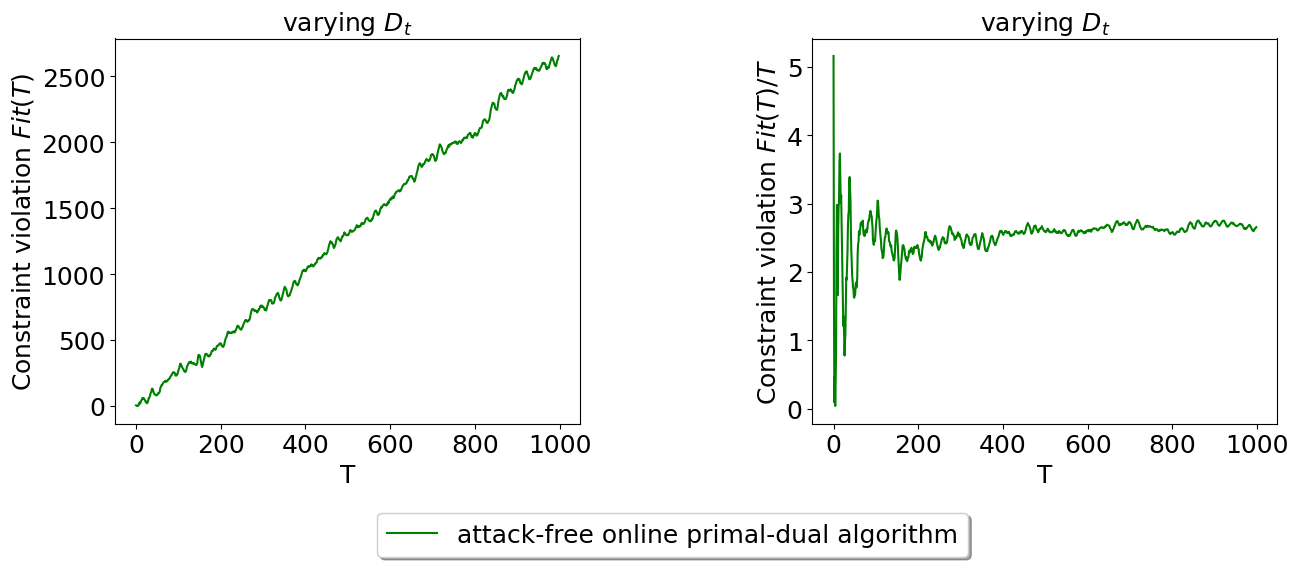

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')